# Importación de librerias

In [1]:
#Se importa la librería tweepy (API de twitter)
import tweepy

In [2]:
#Manipulación de datos
import pandas as pd
import os
#acceso a la plataforma drive
from google.colab import drive
drive.mount('/content/drive')

#Se importa sleep, datetime, TextBlob y matplotlib
from time import sleep
from datetime import datetime
from textblob import TextBlob 
import matplotlib.pyplot as plt 
%matplotlib inline

Mounted at /content/drive


# Permisos desde python a la API


Declaraciónde las credenciales

In [26]:
#Se define las variables para el acceso al API de twitter
consumer_key = 'jcrXiiyO2iA6sxTEGBOxtSjvt'
consumer_secret = 'VAcDyD0oYjAirOUVXWhxPUHQDLxnym3ffrMgG8YcUSJBpfn0bT'
access_token = '1448385775528288261-C4hHEw7vpOKYCvDKERVnULfU3zY8vO'
access_token_secret = 'Ii5dKQVDgi2L0Z3cvmJZI0nyH2l0jzcrH6RUCyU9MRGQu'

Se autentica en twitter

In [43]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

Se rerifica que el usuario sea de uno

In [42]:
print(api.me().name)

#Busqueda y guardado

Se define la cantida de tweets a capturar definiendo:


1.   Palabras a buscar.
3.   Intervalo de tiempo.
4.   Lenguaje de los tweets.





In [44]:
query = 'MatriculaCero'
max_tweets = 1000
lenguaje = "es"

Busqueda de los tweets, dentro de items está la cantidad de tweets a consultar.

In [45]:
searched_tweets = [status for status in tweepy.Cursor(api.search, q=query).items(max_tweets)]

Selección de los tweets según su ubicación

In [46]:
#data_frame = [[tweet.text] for tweet in searched_tweets]

#Arreglo que contendra los tweets antes de pasarlos al dataframe
contenedorAux = []
for tweet in searched_tweets:
  #se busca la subcadena Bogotá en la localizacíon del usuario y se guarda en el contenedor
  if("Bogotá" in tweet.user.location):
    contenedorAux.append([tweet.text])
#data_frame = [[tweet.text] for tweet in tweets]

Guardado en un dataFrame

In [47]:
#se guarda el contenedor en el data frame
data_frame = contenedorAux
#se crea el dataframe
tw_dataframe = pd.DataFrame(data= data_frame , columns=["text"])

Guardado del dataFrame en drive, en un archivo .csv

In [48]:
#se guarda el dataFrame en el drive con extensión csv
tw_dataframe.to_csv('/content/drive/MyDrive/Colab Notebooks/matriculacero.csv', index=False, encoding='utf-8')

# Preprocesamiento

In [45]:
import re  
#variables para mejorar la escritura (opcional)
NORMALIZE = 'normalize'
REMOVE = 'remove'
MENTION = 'twmention'
HASHTAG = 'twhashtag'
URL = 'twurl'
LAUGH = 'jajaja'

#variable para definir si quiero normalizar: normalize o eliminar: remove los hashtags, menciones y urls en los tweets
_twitter_features="normalize"
#variable para definir si se desea tener convertir o no a la raiz de la palabra.
_stemming=False

#lista para corregir algunas palabras coloquiales / jerga en español (obviamente faltan más)
SLANG = [('d','de'), ('[qk]','que'), ('xo','pero'), ('xa', 'para'), ('[xp]q','porque'),('es[qk]', 'es que'),
         ('fvr','favor'),('(xfa|xf|pf|plis|pls|porfa)', 'por favor'), ('dnd','donde'), ('tb', 'también'),
         ('(tq|tk)', 'te quiero'), ('(tqm|tkm)', 'te quiero mucho'), ('x','por'), ('\+','mas')]

In [46]:
#metodo para normalizar las risas
def normalize_laughs(message):
  message = re.sub(r'\b(?=\w*[j])[aeiouj]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(?=\w*[k])[aeiouk]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(?=\w*[h])[aeiouk]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(juas+|lol)\b', LAUGH, message, flags=re.IGNORECASE)
  return message

In [ ]:
print(normalize_laughs("esto muyy feliz jajajajaja o no tan feliz jejejejeje o mejor me rio a como papa noel JOJOJO o como en mileniams LOL "))

esto muyy feliz jajaja o no tan feliz jajaja o mejor me rio a como papa noel jajaja o como en mileniams jajaja 


In [47]:


def process_twitter_features(message, twitter_features):

  message = re.sub(r'[\.\,]http','. http', message, flags=re.IGNORECASE)
  message = re.sub(r'[\.\,]#', '. #', message)
  message = re.sub(r'[\.\,]@', '. @', message)

  if twitter_features == REMOVE:
    # eliminar menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))(@|#)\S+', '', message)
    message = re.sub(r'\b(https?:\S+)\b', '', message, flags=re.IGNORECASE)
  elif twitter_features == NORMALIZE:
    # cuando sea necesario se normalizaran las menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))@\S+', MENTION, message)
    message = re.sub(r'((?<=\s)|(?<=\A))#\S+', HASHTAG, message)
    message = re.sub(r'\b(https?:\S+)\b', URL, message, flags=re.IGNORECASE)

  return message



print(process_twitter_features("Rosell, una noche. Adivina quien!! http://t.co/PPAwijRX, jajajAja dime si NO ES DÍVERTIDÓÓ","normalize"))



Rosell, una noche. Adivina quien!! twurl, jajajAja dime si NO ES DÍVERTIDÓÓ


In [48]:
def preprocess(message):
  # convertir a minusculas
  message = message.lower()
        
  # eliminar números, retorno de linea y el tan odios retweet (de los viejos estilos de twitter)
  message = re.sub(r'(\d+|\n|\brt\b)', '', message)
        
  # eliminar caracteres repetidos 
  message = re.sub(r'(.)\1{2,}', r'\1\1', message)
       
  # normalizar las risas
  message = normalize_laughs(message)
        
  # traducir la jerga y terminos coloquiales sobre todo en el español
  for s,t in SLANG:
    message = re.sub(r'\b{0}\b'.format(s), t, message)

  #normalizar/eliminar hashtags, menciones y URL
  message = process_twitter_features(message, _twitter_features)



  return message




print(preprocess("@maestriainv @cadepudfjc @Ipazud @BienestarUDistr @udistrital @proteoandante @wilches7 Pero ya pasó el evento..."))



twmention twmention twmention twmention twmention twmention twmention pero ya pasó el evento..


# Clasificación de los datos

Importación de librerias

In [58]:
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')  
from textblob import TextBlob
import pandas as pd
from textblob.sentiments import NaiveBayesAnalyzer
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
def ObtenerTweets():
  #Se define las listas que capturan la popularidad
  popularidad_list = []
  numeros_list = []
  numero = 1
  with open('/content/drive/My Drive/Colab Notebooks/positivas.txt',"r") as f:
    for line in f.read().split('\n'): 
      try:
        #Se toma el texto, se hace el analisis de sentimiento
        #y se agrega el resultado a las listas
        analisis1 = TextBlob(tweet.text)
        analisis=analisis1.translate(to='en')
        analisis = analisis.sentiment
        popularidad = analisis.polarity
        popularidad_list.append(popularidad)
        numeros_list.append(numero)
        numero = numero + 1
      except tweepy.TweepError as e:
          print(e.reason)
      except StopIteration:
          break
    return (numeros_list,popularidad_list,numero)

In [67]:
def GraficarDatos(numeros_list,popularidad_list,numero):
    axes = plt.gca()
    axes.set_ylim([-1, 2])
    
    plt.scatter(numeros_list, popularidad_list)
    popularidadPromedio = (sum(popularidad_list))/(len(popularidad_list))
    popularidadPromedio = "{0:.0f}%".format(popularidadPromedio * 100)
    time  = datetime.now().strftime("A : %H:%M\n El: %m-%d-%y")
    plt.text(0, 1.25, 
             "Sentimiento promedio:  " + str(popularidadPromedio) + "\n" + time, 
             fontsize=12, 
             bbox = dict(facecolor='none', 
                         edgecolor='black', 
                         boxstyle='square, pad = 1'))
    
    plt.title("Sentimientos sobre " + query + " en twitter")
    plt.xlabel("Numero de tweets")
    plt.ylabel("Sentimiento")
    plt.show()
    

In [68]:
 numeros_list,popularidad_list,numero = ObtenerTweets()

KeyboardInterrupt: ignored

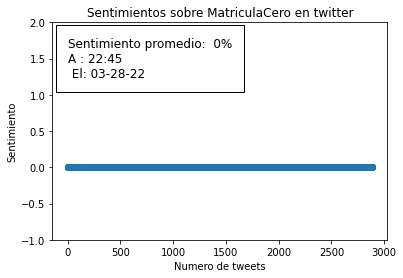

In [65]:
GraficarDatos(numeros_list,popularidad_list,numero)